# Probabilistic Programming 2: Bayesian regression and classification

#### Goal 
  - Learn how to infer a posterior distribution for a linear regression model using a probabilistic programming language.
  - Learn how to infer a posterior distribution for a linear classification model using a probabilistic programming language.
  
#### Materials       
  - Mandatory
    - This notebook.
    - Lecture notes on [regression](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Regression.ipynb).
    - Lecture notes on [discriminative classification](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Discriminative-Classification.ipynb).
  - Optional
    - Bayesian linear regression (Section 3.3 [Bishop](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf))
    - Bayesian logistic regression (Section 4.5 [Bishop](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf))
    - [Cheatsheets: how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

In [1]:
using Pkg
Pkg.activate("../../../lessons/")
Pkg.instantiate();

  Activating project at `~/syndr/Wouter/Onderwijs/Vakken/tueindhoven/5SSD0 - Bayesian Machine Learning & Information Processing/2023-2024 Q2/BMLIP/lessons`


## Problem: Economic growth

In 2008, the credit crisis sparked a recession in the US, which spread to other countries in the ensuing years. It took most countries a couple of years to recover. 
Now, the year is 2011. The Turkish government is asking you to estimate whether Turkey is out of the recession. You decide to look at the data of the national stock exchange to see if there's a positive trend. 

In [2]:
using CSV
using DataFrames
using LinearAlgebra
using Distributions
using StatsFuns
using RxInfer
using Plots
default(label="", margin=10Plots.pt)

### Data

We are going to start with loading in a data set. We have daily measurements from Istanbul, from the 5th of January 2009 until 22nd of February 2011. The dataset comes from an online resource for machine learning data sets: the [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/ISTANBUL+STOCK+EXCHANGE).

In [3]:
# Read CSV file
df = DataFrame(CSV.File("../datasets/stock_exchange.csv"))

Row,date,ISE
,String15,Float64
1,5-Jan-09,0.0357537
2,6-Jan-09,0.0254259
3,7-Jan-09,-0.0288617
4,8-Jan-09,-0.0622081
5,9-Jan-09,0.00985991
6,12-Jan-09,-0.029191
7,13-Jan-09,0.0154453
8,14-Jan-09,-0.0411676
9,15-Jan-09,0.000661905


We can plot the evolution of the stock market values over time.

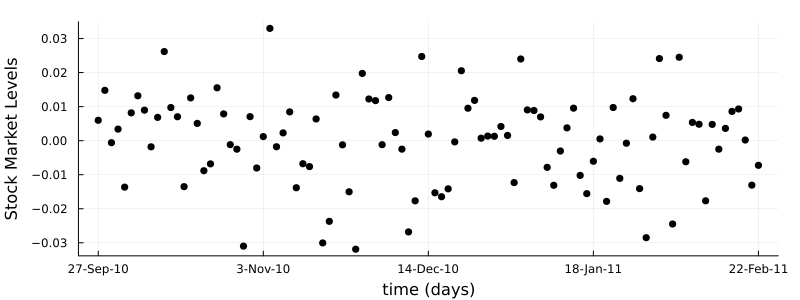

In [4]:
# Count number of samples
time_period = 436:536
num_samples = length(time_period)

# Extract columns
dates_num = 1:num_samples
dates_str = df[time_period,1]
stock_val = df[time_period,2]

# Set xticks
xtick_points = Int64.(round.(range(1, stop=num_samples, length=5)))

# Scatter exchange levels
scatter(dates_num, 
        stock_val, 
        color="black",
        label="", 
        ylabel="Stock Market Levels", 
        xlabel="time (days)",
        xticks=(xtick_points, [dates_str[i] for i in xtick_points]), 
        size=(800,300))

### Model specification

We have a date $x_i \in \mathbb{R}$, referred to as a "covariate" or input variable, and the value of the stock exchange at that time point $y_i \in \mathbb{R}$, referred to as a "response" or output variable. A regression model has parameters $\theta$, used to predict $y = (y_1, \dots, y_N)$ from $x = (x_1, \dots, x_N)$. We are looking for a posterior distribution for the parameters $\theta$:

$$\underbrace{p(\theta \mid y, x)}_{\text{posterior}} \propto\ \underbrace{p(y \mid x, \theta)}_{\text{likelihood}} \cdot \underbrace{p(\theta)}_{\text{prior}}$$

We assume each observation $y_i$ is generated via: 

$$ y_i = f_\theta(x_i) + e_i$$ 

where $e_i$ is white noise, $e_i \sim \mathcal{N}(0, \sigma^2_y)$, and the regression function $f_\theta$ is linear: $f_\theta(x) = x \theta_1 + \theta_2$. The parameters consist of a slope coefficient $\theta_1$ and an intercept $\theta_2$, which are summarized into the vector $\theta = \begin{bmatrix}\theta_1 \\ \theta_2 \end{bmatrix}$. In practice, we augment the data point $x$ with a 1, i.e., $\begin{bmatrix}x \\ 1 \end{bmatrix}$, so that we may define $f_\theta(x) = \theta^{\top}x$. 

#### Likelihood
If we integrate out the noise $e$, then we obtain a Gaussian likelihood function centered on $f_\theta(x)$ with variance $\sigma^2_Y$:

$$p(y_i \mid x_i, \theta) = \mathcal{N}(y_i \mid f_\theta(x_i),\sigma^2_y)\, \ .$$ 

But this is just for a single sample and we have an entire data set. The likelihood of all $(x,y)$ is:

$$\begin{aligned} p(y \mid x, \theta) &= \prod_{i=1}^{N} p(y_i \mid x_i, \theta) \\ & = \prod_{i=1}^{N} \mathcal{N}(y_i \mid f_{\theta}(x_i), \sigma^2_y) \, . \end{aligned} $$ 

#### Prior distribution
We know that the weights are real numbers and that they can be negative. That motivates us to use a Gaussian prior:

$$ p(\theta) = \mathcal{N}(\theta \mid \mu_\theta, \Sigma_\theta) \, .$$

We can specify these equations almost directly in our PPL.

In [5]:
@model function linear_regression(μ_θ, Σ_θ, σ2_y; N=1)
    "Bayesian linear regression"
    
    # Allocate data variables
    X = datavar(Vector{Float64}, N)
    y = datavar(Float64, N)
    
    # Prior distribution of coefficients
    θ ~ MvNormalMeanCovariance(μ_θ, Σ_θ)
    
    for i = 1:N

        # Likelihood of i-th sample
        y[i] ~ NormalMeanVariance(dot(θ,X[i]), σ2_y)
        
    end
    return y, X, θ
end

In [6]:
# Prior parameters
μ_θ, Σ_θ = (zeros(2), diagm(ones(2)))

# Likelihood variance
σ2_y = 1.0;

Now that we have our model, it is time to infer parameters.

In [7]:
# Call inference function
results = inference(
    model       = linear_regression(μ_θ, Σ_θ, σ2_y, N=num_samples),
    data        = (y = stock_val, X = [[dates_num[i], 1.0] for i in 1:num_samples]),
    returnvars  = (θ = KeepLast()),
)

Inference results:
  Posteriors       | available for (θ)


Let's visualize the resulting posterior.

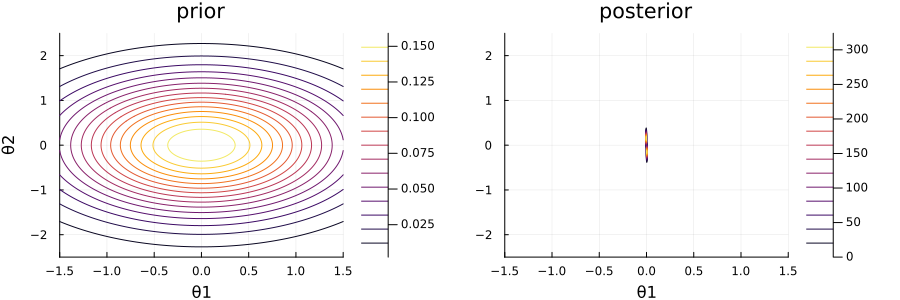

In [8]:
# Extract posterior weights 
post_θ = results.posteriors[:θ]

# Define ranges for plot
x1 = range(-1.5, length=500, stop=1.5)
x2 = range(-2.5, length=500, stop=2.5)

# Draw contour plots of distributions
prior_θ = MvNormal(μ_θ, Σ_θ)
p1a = contour(x1, x2, (x1,x2) -> pdf(prior_θ, [x1,x2]), xlabel="θ1", ylabel="θ2", title="prior", label="")
p1b = contour(x1, x2, (x1,x2) -> pdf(post_θ, [x1,x2]), xlabel="θ1", title="posterior", label="")
plot(p1a, p1b, size=(900,300))

It has become quite sharply peaked in a small area of parameter space.

We can extract the MAP point estimate to compute and visualize the most probable regression function $f_\theta$.

In [9]:
# Extract estimated weights
θ_MAP = mode(post_θ)

# Report results
println("Slope coefficient = "*string(θ_MAP[1]))
println("Intercept coefficient = "*string(θ_MAP[2]))

# Make predictions
regression_estimated = dates_num * θ_MAP[1] .+ θ_MAP[2];

Slope coefficient = -4.320468927301207e-5
Intercept coefficient = 0.002245312220051815


 Let's visualize it.

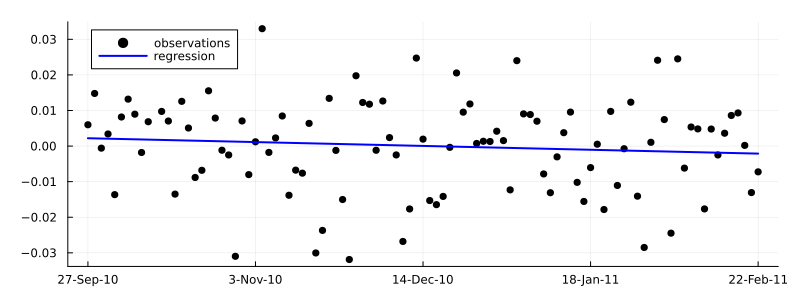

In [10]:
# Visualize observations
scatter(dates_num, stock_val, color="black", xticks=(xtick_points, [dates_str[i] for i in xtick_points]), label="observations", legend=:topleft)

# Overlay regression function
plot!(dates_num, regression_estimated, color="blue", label="regression", linewidth=2, size=(800,300))

The slope coefficient $\theta_1$ is negative and the plot shows a decreasing line. The ISE experienced a negative linear trend from October 2010 up to March 2011. Assuming the stock market is an indicator of economic growth, then we may conclude that in March 2011 the Turkish economy is still in recession.

---

#### Exercise

Change the `time period` variable. Re-run the regression and see how the results change.

---

## Problem: Medical Diagnosis

A company is trying to develop a measurement device that tells a patient whether they suffer from Chronic Obstructive Pulmonary Disease (COPD). They believe they can detect certain compounds in a saliva sample that indicate the presence of COPD. To test the device, they collect data from both COPD patients and healthy controls. They train a classifier and make predictions on a test sample. If the diagnosis can be accurately predicted, then the new device is deemed an informative tool and will be brought to market.

### Data

The data set comes from the [UCI ML Repository](https://archive.ics.uci.edu/dataset/523/exasens). It contains measurements of 79 participants, split into 40 samples for training and 39 for testing. The columns in the data file marked _:x_ are biometric features (x1,x2 = measured signal, x3 = gender, x4 = age, x5 = smoking) and the final column marked _:y_ is the diagnosis (healthy control =0, COPD =1).

In [11]:
# Read CSV file
df = DataFrame(CSV.File("../datasets/diagnosis_train.csv"))

# Split dataframe into features and labels
features_train = Matrix(df[:,1:5])
labels_train = Vector(df[:,6])

# Store number of features
num_features = size(features_train,2)

# Number of training samples
num_train = size(features_train,1);

Let's have a look at measurements from the device.

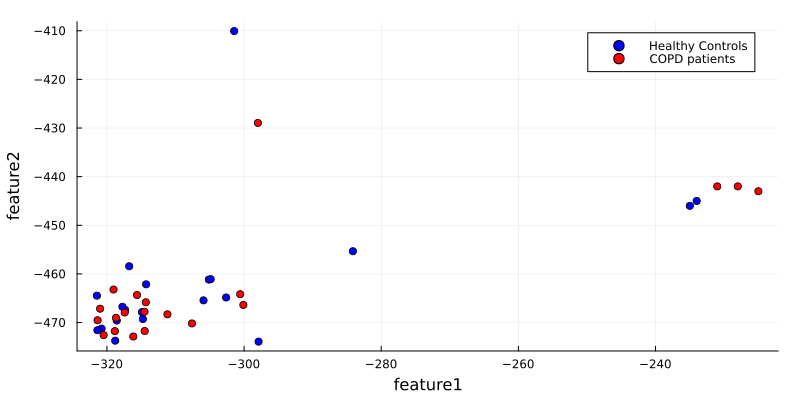

In [12]:
plot(xlabel="feature1", ylabel="feature2", size=(800,400))
scatter!(features_train[labels_train .== 0, 1], features_train[labels_train .== 0, 2], color="blue", label="Healthy Controls")
scatter!(features_train[labels_train .== 1, 1], features_train[labels_train .== 1, 2], color="red",  label="COPD patients")

Mmhh, it doesn't look like the samples can easily be separated. Are these measurements really informative?

---

#### Exercise

The plot above shows features 1 and 2. Have a look at the other combinations of features.

---

### Model specification

We have features $X$, labels $Y$ and parameters $\theta$. Same as with regression, we are looking for a posterior distribution of the classification parameters:

$$\underbrace{p(\theta \mid Y, X)}_{\text{posterior}} \propto\ \underbrace{p(Y \mid X, \theta)}_{\text{likelihood}} \cdot \underbrace{p(\theta)}_{\text{prior}}$$

The likelihood in this case will be of a probit form:

$$ p(Y \mid X, \theta) = \prod_{i=1}^{N} \ \mathcal{B} \big(Y_i \mid \Phi(f_\theta(X_i) \big) \, .$$ 

As you can see it is a Bernoulli distribution with a cumulative normal distribution as transfer (a.k.a. _link_) function: 

$$ \Phi(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{x} \exp \left(-\frac{t^2}{2} \right) \mathrm{d}t \, .$$ 

The transfer function maps the input ($f_\theta(X_i)$) to the interval $(0,1)$ so that the result acts as a rate parameter to the Bernoulli. Check Bert's lecture on discriminative classification for more information.

We will use a Gaussian prior distribution for the classification parameters $\theta$:

$$ p(\theta) = \mathcal{N}(\theta \mid \mu_\theta, \Sigma_\theta) \, .$$

You have probably noticed that this combination of likelihood and prior is not part of the family of conjugate pairings. As such, we don't have an exact posterior. The Laplace approximation is one procedure but under the hood, our toolbox is actually performing a different procedure for obtaining the posterior parameters: [moment matching](https://en.wikipedia.org/wiki/Method_of_moments_(statistics)). The cumulative normal distribution allows for integrating the product of prior and likelihood by hand, with respect to the first (mean) and second (variance) moments. The toolbox is essentially performing a lookup for the analytically derived formula, which computationally cheaper than performing the iterative steps necessary for the Laplace approximation.

In [13]:
# Parameters for priors
μ_θ = zeros(num_features+1,)
Σ_θ = diagm(ones(num_features+1));

In [14]:
@model function linear_classification(μ_θ, Σ_θ; N=1)
    "Bayesian classification model"
    
    # Allocate data variables
    X = datavar(Vector{Float64}, N)
    y = datavar(Float64, N)
    
    # Weight prior distribution
    θ ~ MvNormalMeanCovariance(μ_θ, Σ_θ)
    
    # Binary likelihood
    for i = 1:N
        y[i] ~ Probit(dot(θ, X[i]))
    end
    
    return y, X, θ
end

In [15]:
results = inference(
    model       = linear_classification(μ_θ, Σ_θ, N=num_train),
    data        = (y = labels_train, X = [[features_train[i,:]; 1.0] for i in 1:num_train]),
    returnvars  = (θ = KeepLast()),
    iterations  = 10,
)

Inference results:
  Posteriors       | available for (θ)


Unfortunately, we cannot visualize a distribution of more than 2 dimensions. But we can visualize a pair of dimensions:

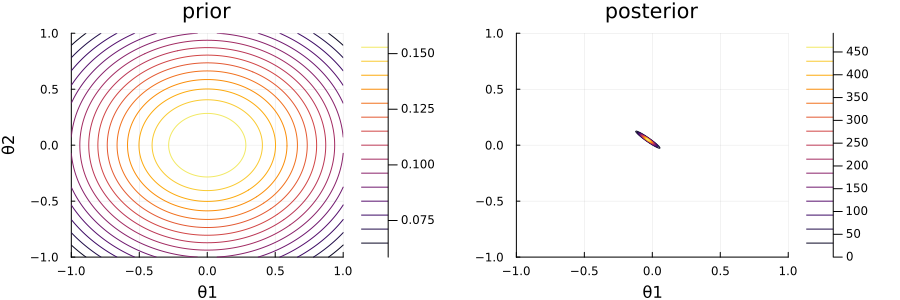

In [16]:
# Coefficients to visualize
cix = [1,2]

# Reduce posterior distribution to chosen dimensions
m_cix = mean(results.posteriors[:θ])[cix]
S_cix = cov( results.posteriors[:θ])[cix,cix]
post_θ = MvNormal(m_cix, S_cix)

# Reduce prior distribution to chosen dimensions
prior_θ = MvNormal(μ_θ[cix], Σ_θ[cix,cix])

# Define ranges for plot
x1 = range(-1., length=500, stop=1.)
x2 = range(-1., length=500, stop=1.)

# Draw contour plots of distributions
p1a = contour(x1, x2, (x1,x2) -> pdf(prior_θ, [x1,x2]), xlabel="θ1", ylabel="θ2", title="prior", label="")
p1b = contour(x1, x2, (x1,x2) -> pdf(post_θ, [x1,x2]), xlabel="θ1", title="posterior", label="")
plot(p1a, p1b, size=(900,300))

### Predict test data

In [17]:
# Read CSV file
df = DataFrame(CSV.File("../datasets/diagnosis_test.csv"))

# Split dataframe into features and labels
features_test = Matrix(df[:,1:5])
labels_test = Vector(df[:,6])

# Number of test samples
num_test = size(features_test,1);

You can classify test samples by taking the MAP for the classification parameters, computing the linear function $f_\theta$ and rounding the result to obtain the most probable label.

In [18]:
# Extract MAP estimate of classification parameters
θ_MAP = mode(results.posteriors[:θ])

# Compute dot product between parameters and test data
fθ_pred = [features_test ones(num_test,)] * θ_MAP

# Predict labels through probit
labels_pred = round.(normcdf.(fθ_pred));

# Compute classification accuracy of test data
accuracy_test = mean(labels_test .== labels_pred)

# Report result
println("Test Accuracy = "*string(accuracy_test*100)*"%")

Test Accuracy = 92.3076923076923%


Those predictions are very accurate. So, is the device informative after all?

---

#### Exercise

Re-run the classifier on just the saliva measurement features. Does the accuracy drop? And if so, should the device be used?

---